# ARTIFICIAL NEURAL NETWORK FOR REGRESSION

In [106]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
# model dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [107]:
# Create connection to remote MySQL database
hostname = "gator3228.hostgator.com"
username = "rbrennan_sm_jb"
password = "This_is_not_the_password"
database = "rbrennan_stock_project_4"
# Create a database connection
db_url = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{database}"
engine = create_engine(db_url)
# Test the connection
try:
    conn = engine.connect()
    print("Connected to MySQL database")
except Exception as e:
    print("Error:", e)
nikola_df = pd.read_sql("SELECT * FROM Nikola", conn)

nikola_df.head()

Connected to MySQL database


,Date,Open,High,Low,Close,Volume
0,2018-06-12,9.56,9.56,9.56,9.56,300000
1,2018-06-13,9.57,9.58,9.56,9.57,179100
2,2018-06-14,9.57,9.57,9.57,9.57,0
3,2018-06-15,9.57,9.57,9.57,9.57,0
4,2018-06-18,9.54,9.58,9.54,9.58,300


In [108]:
# Set date column as the index
nikola_df.set_index('Date', inplace=True)

nikola_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-06-12,9.56,9.56,9.56,9.56,300000
2018-06-13,9.57,9.58,9.56,9.57,179100
2018-06-14,9.57,9.57,9.57,9.57,0
2018-06-15,9.57,9.57,9.57,9.57,0
2018-06-18,9.54,9.58,9.54,9.58,300


In [109]:
# Obtain info on DF columns
nikola_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1326 entries, 2018-06-12 to 2023-09-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1326 non-null   float64
 1   High    1326 non-null   float64
 2   Low     1326 non-null   float64
 3   Close   1326 non-null   float64
 4   Volume  1326 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 62.2 KB


In [110]:
# Investigate correlation between target (Close) and features
nikola_df.corr()['Close'].sort_values(ascending=False)

Close     1.000000
High      0.997549
Low       0.993739
Open      0.991691
Volume   -0.033697
Name: Close, dtype: float64

In [111]:
nikola_df.describe()

,Open,High,Low,Close,Volume
count,1326.000000,1326.000000,1326.000000,1326.000000,1.326000e+03
mean,11.854304,12.249530,11.404784,11.808989,1.482669e+07
std,10.904212,11.526842,10.052450,10.790340,2.949874e+07
min,0.557000,0.570000,0.521000,0.542000,0.000000e+00
25%,6.797500,7.206250,6.567500,6.792500,6.047500e+04
50%,10.040000,10.060000,9.990000,10.030000,8.754650e+06
75%,11.897500,12.200000,11.335000,11.767500,1.531118e+07
max,93.129997,93.989998,70.199997,79.730003,3.856128e+08


<Axes: >

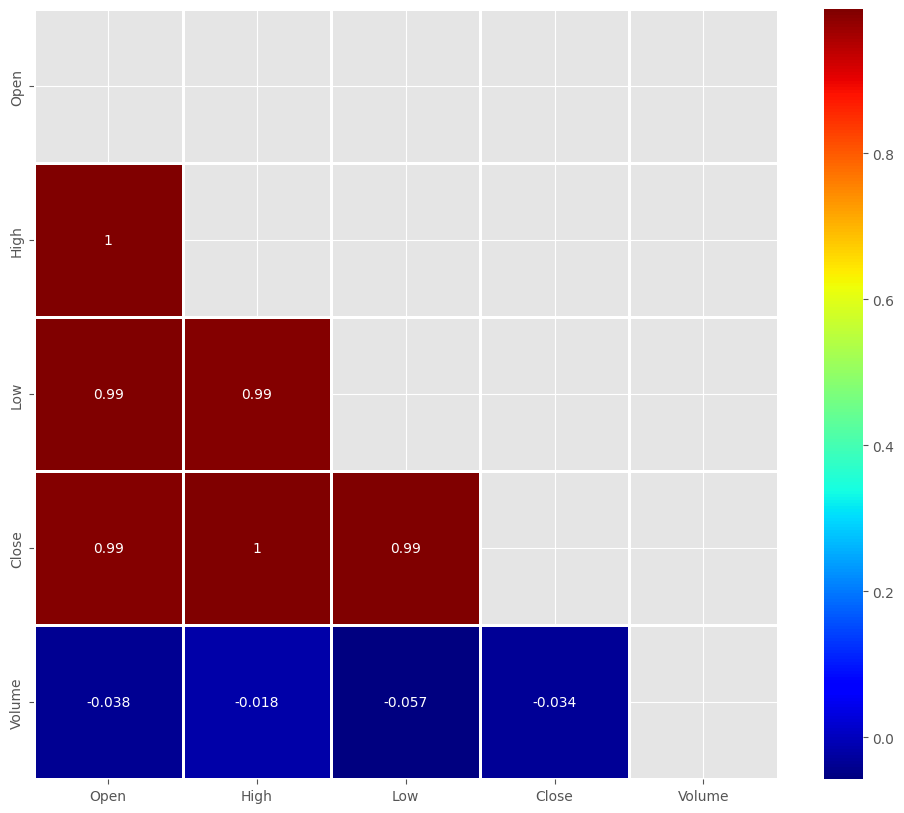

In [112]:
# Heatmap viz of correlations
plt.figure(figsize=(12,10))
mask = np.zeros_like(nikola_df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=nikola_df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [113]:
# MODEL PREPERATION AND TRAINING
X = nikola_df.drop('Close', axis=1)#.values
y = nikola_df['Close']#.values

print(X)
print(y)

             Open   High    Low     Volume
Date                                      
2018-06-12  9.560  9.560  9.560     300000
2018-06-13  9.570  9.580  9.560     179100
2018-06-14  9.570  9.570  9.570          0
2018-06-15  9.570  9.570  9.570          0
2018-06-18  9.540  9.580  9.540        300
...           ...    ...    ...        ...
2023-09-12  0.889  0.914  0.826   99803800
2023-09-13  0.910  0.913  0.850   68874900
2023-09-14  0.871  1.190  0.855  235670400
2023-09-15  1.330  1.380  1.150  271454100
2023-09-18  1.240  1.630  1.230  306512500

[1326 rows x 4 columns]
Date
2018-06-12    9.560
2018-06-13    9.570
2018-06-14    9.570
2018-06-15    9.570
2018-06-18    9.580
              ...  
2023-09-12    0.912
2023-09-13    0.870
2023-09-14    1.150
2023-09-15    1.190
2023-09-18    1.590
Name: Close, Length: 1326, dtype: float64


In [114]:
# Split the data for training as testing 
# Testing initially set to 20% of data 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Save dates into Var
train_dates = X_train.index
test_dates = X_test.index

(1060, 4)
(266, 4)
(1060,)
(266,)


In [115]:
X_train.describe()

,Open,High,Low,Volume
count,1060.000000,1060.000000,1060.000000,1.060000e+03
mean,14.271410,14.743862,13.739021,9.021600e+06
std,10.920556,11.611396,9.945727,1.379005e+07
min,4.650000,4.910000,4.415000,0.000000e+00
25%,9.650000,9.680000,9.590000,1.057500e+04
50%,10.230000,10.260000,10.200000,6.715900e+06
75%,14.151750,14.762500,13.612500,1.267575e+07
max,93.129997,93.989998,70.199997,1.385377e+08


In [116]:
X_test.describe()

,Open,High,Low,Volume
count,266.000000,266.000000,266.00000,2.660000e+02
mean,2.222226,2.309711,2.10294,3.795976e+07
std,1.195196,1.221281,1.14746,5.402759e+07
min,0.557000,0.570000,0.52100,2.976200e+06
25%,1.270000,1.332500,1.18000,1.098495e+07
50%,2.225000,2.330000,2.11500,1.798465e+07
75%,2.747500,2.885000,2.55750,4.098772e+07
max,6.250000,6.290000,5.87500,3.856128e+08


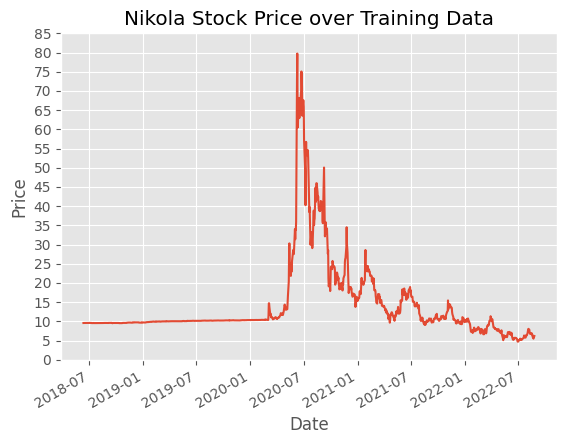

In [144]:
y_train.plot()
plt.yticks(np.arange(0,90,5))
plt.title("Nikola Stock Price over Training Data")
plt.ylabel("Price")
plt.show()

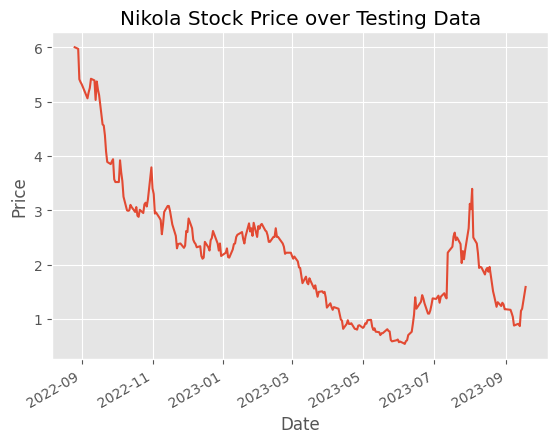

In [143]:
# Note the values of the testing data all being under 6, where training values are much higher
y_test.plot()
plt.title("Nikola Stock Price over Testing Data")
plt.ylabel("Price")
plt.show()

In [119]:
# Scaling the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)
print(X_test)

[[-0.43162953 -0.44665683 -0.42038087 -0.63275473]
 [-0.4307134  -0.44493357 -0.42038087 -0.64152606]
 [-0.4307134  -0.4457952  -0.41937493 -0.65451982]
 ...
 [-0.79075507 -0.7533969  -0.82074161  0.25128522]
 [-0.7715162  -0.74478061 -0.80062298 -0.05798946]
 [-0.73945142 -0.72323987 -0.77547469 -0.05868595]]
[[-0.73487074 -0.72840965 -0.79106663 -0.09059357]
 [-0.76876779 -0.73530268 -0.79458739 -0.20856762]
 [-0.77426461 -0.75942831 -0.84890769  0.55504609]
 ...
 [-1.2276606  -1.16784066 -1.29604425 16.44343915]
 [-1.18560993 -1.1514697  -1.26636927 19.03955743]
 [-1.19385516 -1.12992896 -1.25832182 21.58305498]]


## Keras Tuner code cells are commented out after hyperparameters were discovered, they are expressed in model layer building cell below

In [120]:
# # Create a method that creates a new Sequential model with hyperparameter options
# def create_model(hp):
#     art_nnet = Sequential()

#     # Allow kerastuner to decide which activation function to use in hidden layers
#     activation = hp.Choice('activation',['relu','tanh'])
    
#     # Allow kerastuner to decide number of neurons in first layer
#     art_nnet.add(Dense(units=hp.Int('first_units',
#         min_value=1,
#         max_value=30,
#         step=5), activation=activation, input_dim=4))

#     # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
#     for i in range(hp.Int('num_layers', 1, 5)):
#         art_nnet.add(Dense(units=hp.Int('units_' + str(i),
#             min_value=1,
#             max_value=30,
#             step=5),
#             activation=activation))
    
#     art_nnet.add(Dense(units=1))

#     # Compile the model
#     art_nnet.compile(loss="mean_squared_error", optimizer='adam')
    
#     return art_nnet

In [121]:
# # Import the kerastuner library
# import keras_tuner as kt

# tuner = kt.RandomSearch(
#     create_model,
#     objective=kt.Objective("loss", direction="min"),  # "val_loss", direction= "min"
#     #max_epochs=20,
#     overwrite=True,
#     max_trials=20)
#     #hyperband_iterations=2)

In [122]:
# Run the kerastuner search for best hyperparameters
#tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

In [123]:
# art_nnet = tuner.get_best_models()[0]
# art_nnet.summary()

In [124]:
# best_params = tuner.get_best_hyperparameters()
# best_params[0].values

In [125]:
#art_nnet.evaluate(X_test, y_test)

In [126]:
# Define Artificial Neural Net
art_nnet = Sequential()

# Adding First Hidden Layer
art_nnet.add(Dense(units=11, activation="relu")) #11 units orig

# Adding Second Hidden Layer 
art_nnet.add(Dense(units=26, activation="relu")) #26 units orig

# Adding Third Hidden Layer
art_nnet.add(Dense(units=21, activation="relu")) #21 orig

# Adding Fourth Hidden Layer
art_nnet.add(Dense(units=16, activation="relu")) #16 orig

# Output Layer
art_nnet.add(Dense(units=1))


## Optimizing Attempts
1. Adding 3rd hidden layer (matching param)
2. Increased training data to 90%, lowered accuracy MAE: 10.496

3. with tutor removed early stopping, improved initial predictions. Spikes at end remained
4. Increased neurons on last by x5, minimal effect. Changed back to original.

In [127]:
# Compiling the model
art_nnet.compile(optimizer="adam",loss="mean_squared_error")

In [128]:
# Train the model 
art_nnet.fit(x=X_train, y=y_train, epochs=100, batch_size=32,validation_data=(X_test,y_test)) #\
          #   ,callbacks=EarlyStopping(monitor='val_loss',patience=4))

Epoch 1/100
34/34 [==============================] - 2s 8ms/step - loss: 304.2745 - val_loss: 4.5786
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 242.9459 - val_loss: 35.0484
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 90.6443 - val_loss: 409.3751
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 26.0018 - val_loss: 382.3514
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 11.8541 - val_loss: 374.7101
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 7.1579 - val_loss: 305.0738
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 5.8055 - val_loss: 220.6494
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 4.5802 - val_loss: 205.8326
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 3.8866 - val_loss: 191.2529
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 3.3619 - val_

In [129]:
# Evaluating the loss 
loss_history = pd.DataFrame(art_nnet.history.history)
loss_history

,loss,val_loss
0,304.274536,4.578618
1,242.945908,35.048431
2,90.644295,409.375092
3,26.001804,382.351440
4,11.854099,374.710052
...,...,...
95,0.286090,6.265987
96,0.255019,6.556689
97,0.283075,6.514793
98,0.283841,5.416117


Text(0, 0.5, 'Loss')

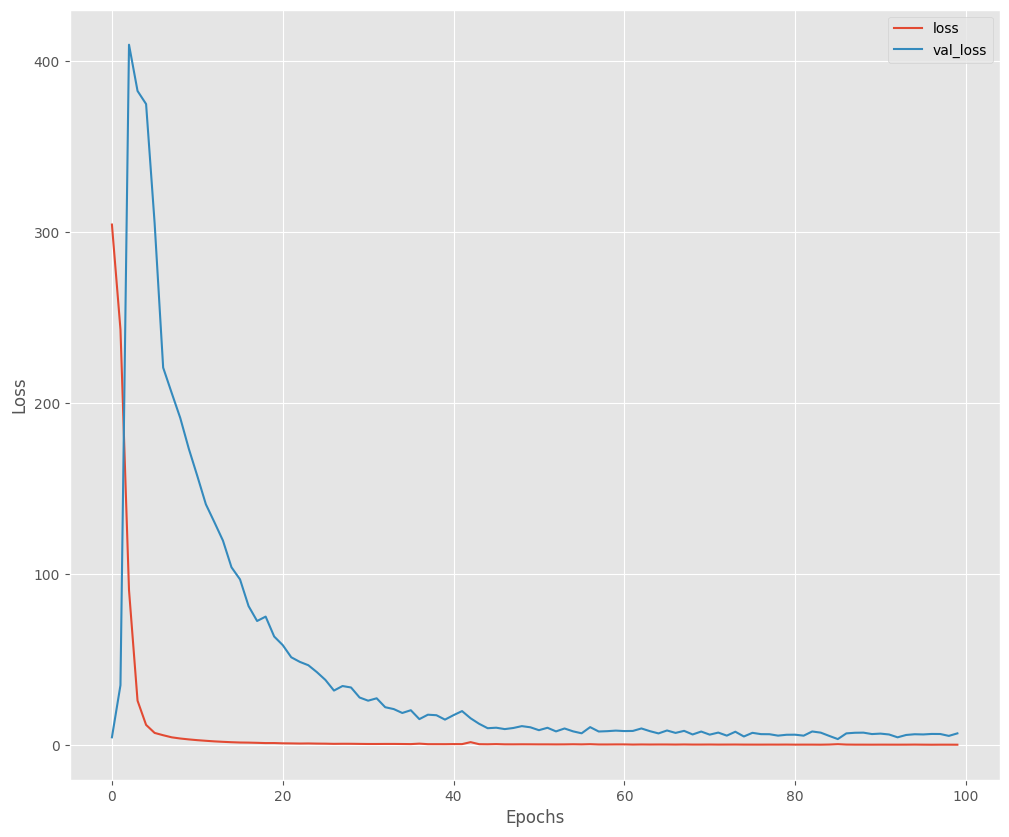

In [130]:
# Visualize the loss DF above 
plt.style.use("ggplot")
pd.DataFrame(art_nnet.history.history).plot(figsize=(12,10))
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [131]:
# Evaluate the Training & Testing 
print(f'Training Evaluation: {art_nnet.evaluate(X_train, y_train)}')
print(f'Testing Evaluation: {art_nnet.evaluate(X_test, y_test)}')


34/34 [==============================] - 0s 2ms/step - loss: 0.3029
Training Evaluation: 0.3028564453125
9/9 [==============================] - 0s 2ms/step - loss: 6.8891
Testing Evaluation: 6.889130592346191


In [132]:
# Make Predictions 
ann_predictions = art_nnet.predict(X_test)
predictions_df = pd.DataFrame(np.ravel(ann_predictions),columns=["Predictions"])
comparison_df = pd.concat([pd.DataFrame(y_test.values,columns=["Real Values"]), predictions_df],axis=1)
comparison_df

9/9 [==============================] - 0s 1ms/step


,Real Values,Predictions
0,6.000,6.154853
1,5.970,6.384948
2,5.410,5.818965
3,5.360,5.422255
4,5.320,5.306706
...,...,...
261,0.912,4.403028
262,0.870,3.525506
263,1.150,9.669909
264,1.190,10.638220


In [133]:
y_test

Date
2022-08-26    6.000
2022-08-29    5.970
2022-08-30    5.410
2022-08-31    5.360
2022-09-01    5.320
              ...  
2023-09-12    0.912
2023-09-13    0.870
2023-09-14    1.150
2023-09-15    1.190
2023-09-18    1.590
Name: Close, Length: 266, dtype: float64

In [134]:
# Check shapes of test-target and predictions 
print(y_test.shape)
print(ann_predictions.shape)

(266,)
(266, 1)


c:\Users\justi\anaconda3\envs\tensorflow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\justi\anaconda3\envs\tensorflow\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Actual Values')

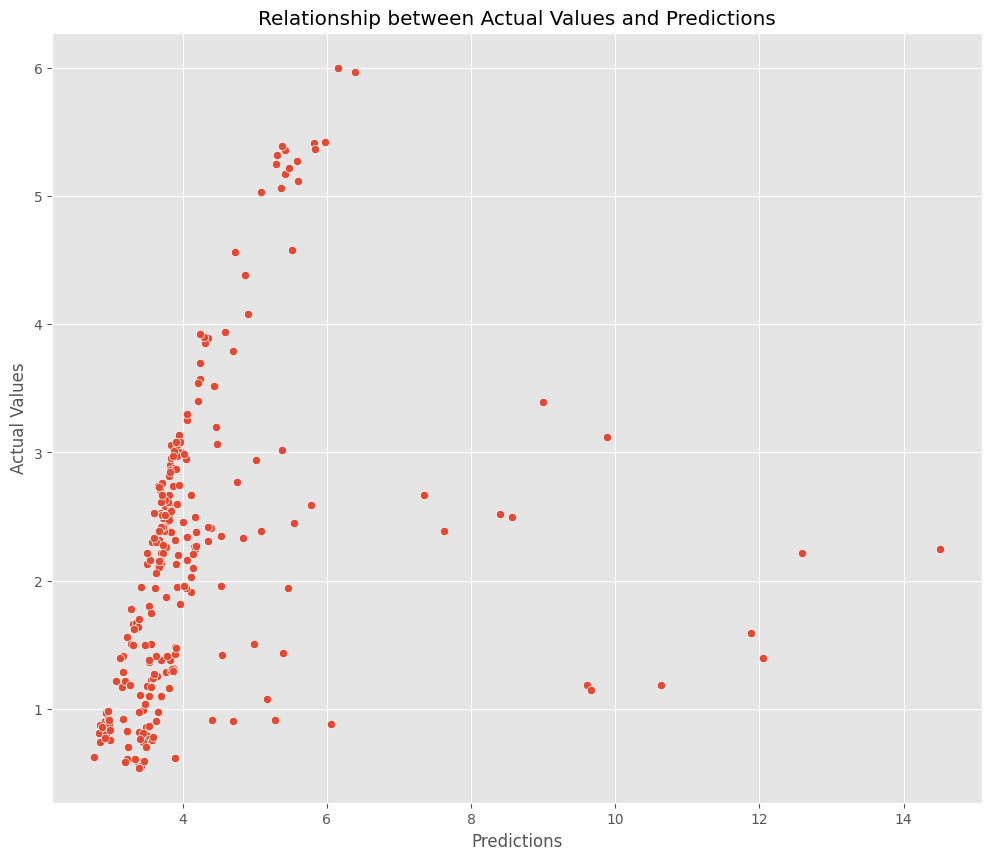

In [135]:
# Visualize test values against predictions
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.ravel(ann_predictions),y=y_test)
plt.title("Relationship between Actual Values and Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")

In [136]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
# Evaluate the model performance with the residual of squares and the explained variance score

# Mean Absolute Error
print("MAE:",metrics.mean_absolute_error(y_test,ann_predictions))
# Mean Squared Error
print ("MSE:",metrics.mean_squared_error(y_test,ann_predictions))
# Square Root of MSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,ann_predictions)))
# Explained Variance Score, which shows how correctly the model predicts the target as a %, the closer to 100% the better
print("EVS:",metrics.explained_variance_score(y_test,ann_predictions))

MAE: 2.0241936524039823
MSE: 6.8891314938500035
RMSE: 2.624715507221688
EVS: -1.032876859183038


In [137]:
X_test

array([[-0.73487074, -0.72840965, -0.79106663, -0.09059357],
       [-0.76876779, -0.73530268, -0.79458739, -0.20856762],
       [-0.77426461, -0.75942831, -0.84890769,  0.55504609],
       ...,
       [-1.2276606 , -1.16784066, -1.29604425, 16.44343915],
       [-1.18560993, -1.1514697 , -1.26636927, 19.03955743],
       [-1.19385516, -1.12992896, -1.25832182, 21.58305498]])

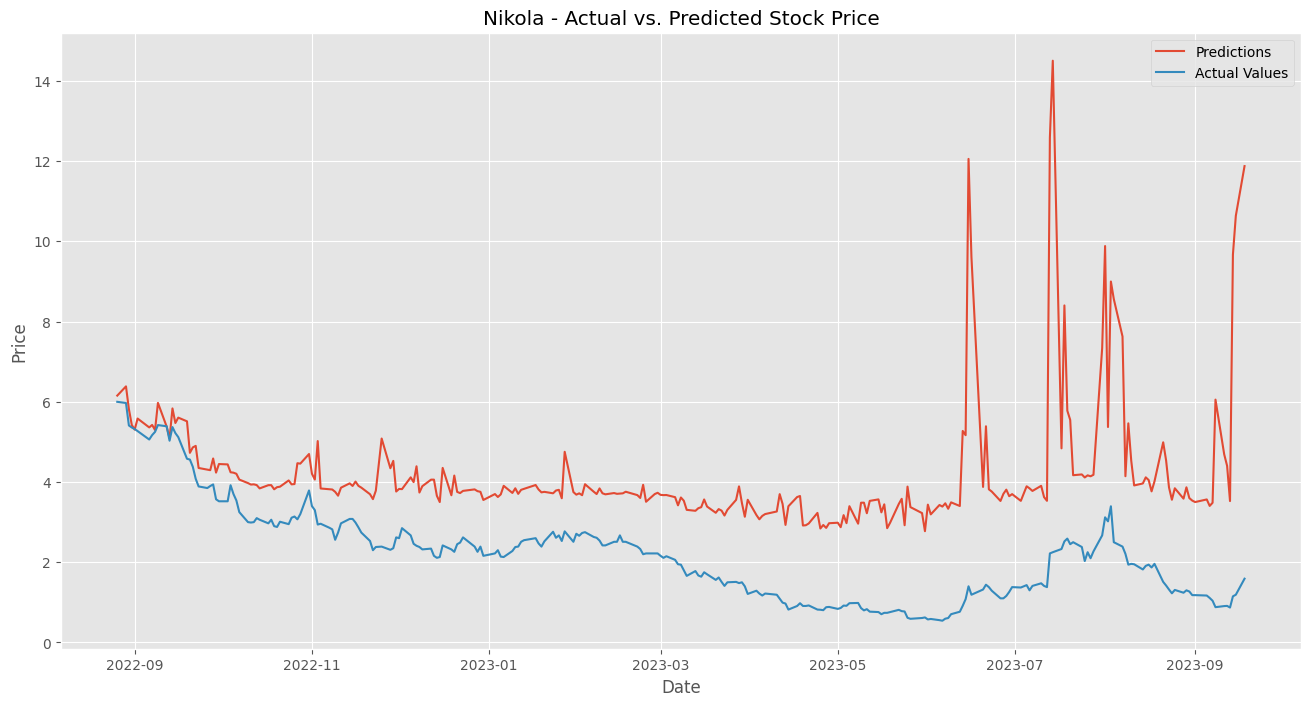

In [140]:
# Visualize Predictions vs Actual Stock prices 
plt.figure(figsize=(16,8))
plt.plot(test_dates, ann_predictions, label='Predictions')
plt.plot(test_dates, y_test, label='Actual Values')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nikola - Actual vs. Predicted Stock Price')
plt.show()

In [139]:
# Save model as an .h5 model
art_nnet.save("nikola_annreg.h5")

c:\Users\justi\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
